In [68]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
import gc
from tqdm import tqdm

In [2]:
# Load datasets
train = pd.read_csv('train.csv')
gas_prices = pd.read_csv('gas_prices.csv')
client = pd.read_csv('client.csv')
electricity_prices = pd.read_csv('electricity_prices.csv')
forecast_weather = pd.read_csv('forecast_weather.csv')
historical_weather = pd.read_csv('historical_weather.csv')

In [3]:
# Check of null values
print("train_df:\n\n", train.isnull().sum())
print("gas_prices_df:\n\n", gas_prices.isnull().sum())
print("client_df:\n\n", client.isnull().sum())
print("electricity_prices_df:\n\n", electricity_prices.isnull().sum())
print("forecast_weather_df:\n\n", forecast_weather.isnull().sum())
print("historical_weather_df:\n\n", historical_weather.isnull().sum())

train_df:

 county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64
gas_prices_df:

 forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64
client_df:

 product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64
electricity_prices_df:

 forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64
forecast_weather_df:

 latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_

In [4]:
train['target'].isnull().mean() * 100

0.026159956241527744

In [1]:
##### Since the null values in the target column of the train dataset is just 0.02%, we can drop them instead of imputing

In [5]:
train.dropna(inplace=True)

In [6]:
train.isnull().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [7]:
forecast_weather.isnull().mean() * 100

latitude                             0.000000
longitude                            0.000000
origin_datetime                      0.000000
hours_ahead                          0.000000
temperature                          0.000000
dewpoint                             0.000000
cloudcover_high                      0.000000
cloudcover_low                       0.000000
cloudcover_mid                       0.000000
cloudcover_total                     0.000000
10_metre_u_wind_component            0.000000
10_metre_v_wind_component            0.000000
data_block_id                        0.000000
forecast_datetime                    0.000000
direct_solar_radiation               0.000000
surface_solar_radiation_downwards    0.000058
snowfall                             0.000000
total_precipitation                  0.000000
dtype: float64

In [2]:
# Null values are very small in number so just dropping them

In [8]:
forecast_weather.dropna(inplace=True)

In [9]:
forecast_weather.isnull().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
dtype: int64

In [10]:
train[(train['county'] == 0) & (train['product_type']  == 1) & (train['is_business'] == 1) & (train['datetime'] == '2021-09-01 00:00:00')]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
8,0,1,1,0.00,0,2021-09-01 00:00:00,0,8,4
9,0,1,1,501.76,1,2021-09-01 00:00:00,0,9,4


In [11]:
train[(train['county'] == 0) & (train['product_type']  == 1) & (train['is_business'] == 1) & (train['is_consumption'] == 1)]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
9,0,1,1,501.760,1,2021-09-01 00:00:00,0,9,4
131,0,1,1,486.297,1,2021-09-01 01:00:00,0,131,4
253,0,1,1,458.562,1,2021-09-01 02:00:00,0,253,4
375,0,1,1,511.794,1,2021-09-01 03:00:00,0,375,4
497,0,1,1,520.318,1,2021-09-01 04:00:00,0,497,4
...,...,...,...,...,...,...,...,...,...
2017711,0,1,1,761.060,1,2023-05-31 19:00:00,637,2017711,4
2017841,0,1,1,827.122,1,2023-05-31 20:00:00,637,2017841,4
2017971,0,1,1,808.137,1,2023-05-31 21:00:00,637,2017971,4
2018101,0,1,1,870.630,1,2023-05-31 22:00:00,637,2018101,4


In [12]:
train['is_business'].unique()

array([0, 1], dtype=int64)

<Axes: >

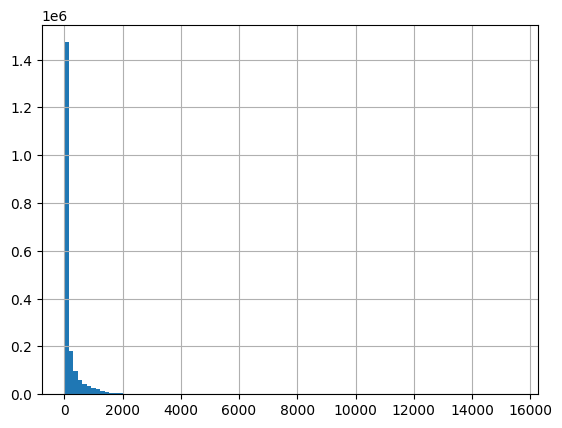

In [13]:
train['target'].hist(bins=100)

In [14]:
train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id'],
      dtype='object')

In [15]:
gas_prices.columns

Index(['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'origin_date', 'data_block_id'],
      dtype='object')

In [16]:
# Seperating date and time from datetime to train the model on seasonality
train['date'] = pd.to_datetime(train['datetime']).dt.date
train['time'] = pd.to_datetime(train['datetime']).dt.time

In [17]:
# Extract year, month, date and day of the week to train model on seasonality
train['year'] = pd.to_datetime(train['datetime']).dt.year
train['month'] = pd.to_datetime(train['datetime']).dt.month
train['day'] = pd.to_datetime(train['datetime']).dt.day
train['dayofweek'] = pd.to_datetime(train['datetime']).dt.dayofweek

In [3]:
# Extract hours to train model based on the time
train['hour'] = pd.to_datetime(train['datetime']).dt.hour
train['minutes'] = pd.to_datetime(train['datetime']).dt.minute
train['seconds'] = pd.to_datetime(train['datetime']).dt.second

NameError: name 'pd' is not defined

In [19]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,time,year,month,day,dayofweek,hour,minutes,seconds
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,00:00:00,2021,9,1,2,0,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,00:00:00,2021,9,1,2,0,0,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,00:00:00,2021,9,1,2,0,0,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,00:00:00,2021,9,1,2,0,0,0


In [20]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [21]:
client['date'] = pd.to_datetime(client['date']).dt.date

In [22]:
train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date',
       'time', 'year', 'month', 'day', 'dayofweek', 'hour', 'minutes',
       'seconds'],
      dtype='object')

In [23]:
client.columns

Index(['product_type', 'county', 'eic_count', 'installed_capacity',
       'is_business', 'date', 'data_block_id'],
      dtype='object')

In [24]:
df = pd.merge(train, client.drop(columns=['date']), how='left', on=['county', 'product_type', 'is_business', 'data_block_id'])

In [25]:
electricity_prices['date'] = pd.to_datetime(electricity_prices['forecast_date']).dt.date
electricity_prices['time'] = pd.to_datetime(electricity_prices['forecast_date']).dt.time

In [26]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id,date,time
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1,2021-09-01,00:00:00
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1,2021-09-01,01:00:00
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1,2021-09-01,02:00:00
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1,2021-09-01,03:00:00
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1,2021-09-01,04:00:00


In [27]:
df = df.merge(electricity_prices.drop(columns=['forecast_date', 'origin_date']), how='left', on=['date', 'time', 'data_block_id'])

In [28]:
df = df.merge(gas_prices.drop(columns=['origin_date']), how='left', left_on=['date', 'data_block_id'], right_on=['forecast_date', 'data_block_id']).drop(columns=['forecast_date'])

In [29]:
# Grouping by date and aggregating by min, mean, max and std of temperature and all other features
dict_agg = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            '10_metre_u_wind_component' : ['min', 'mean', 'max', 'std'],
            '10_metre_v_wind_component' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'surface_solar_radiation_downwards' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'total_precipitation' : ['min', 'mean', 'max', 'std'],
           }

agg_df = forecast_weather.groupby(['forecast_datetime']).agg(dict_agg).reset_index()

agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

agg_df['date'] = pd.to_datetime(agg_df['forecast_datetime_']).dt.date
agg_df['time'] = pd.to_datetime(agg_df['forecast_datetime_']).dt.time

agg_df.drop(columns=['forecast_datetime_'], inplace = True)

agg_df.head()

,temperature_min,temperature_mean,temperature_max,temperature_std,dewpoint_min,dewpoint_mean,dewpoint_max,dewpoint_std,cloudcover_high_min,cloudcover_high_mean,...,snowfall_min,snowfall_mean,snowfall_max,snowfall_std,total_precipitation_min,total_precipitation_mean,total_precipitation_max,total_precipitation_std,date,time
0,9.637109,13.062975,16.073999,1.845039,8.423364,10.690589,12.878687,1.176065,0.0,0.292374,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,2021-09-01,03:00:00
1,9.298120,12.963464,16.201807,1.867891,8.287012,10.582913,12.621118,1.083296,0.0,0.271825,...,0.0,0.0,0.0,0.0,-8.195639e-07,8.141090e-07,0.000023,0.000003,2021-09-01,04:00:00
2,9.300684,12.832809,16.193872,1.880105,8.154810,10.455104,12.575098,1.038305,0.0,0.255049,...,0.0,0.0,0.0,0.0,-1.311302e-06,6.782689e-07,0.000015,0.000002,2021-09-01,05:00:00
3,9.729150,12.867699,16.198022,1.727293,8.624780,10.403001,12.527612,0.950091,0.0,0.271870,...,0.0,0.0,0.0,0.0,0.000000e+00,1.333654e-06,0.000026,0.000004,2021-09-01,06:00:00
4,11.033960,13.339924,15.840112,1.214191,8.849512,10.518761,12.416040,0.761944,0.0,0.248376,...,0.0,0.0,0.0,0.0,0.000000e+00,1.371439e-06,0.000024,0.000004,2021-09-01,07:00:00


In [30]:
df = df.merge(agg_df, how='left', on=['date', 'time'])

In [31]:
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [32]:
# Grouping by date and aggregating by min, mean, max and std of temperature and all other features
dict_agg_hist = {'temperature' : ['min', 'mean', 'max', 'std'],
            'dewpoint' : ['min', 'mean', 'max', 'std'],
            'rain' : ['min', 'mean', 'max', 'std'],
            'snowfall' : ['min', 'mean', 'max', 'std'],
            'surface_pressure' : ['min', 'mean', 'max', 'std'],
            'cloudcover_total' : ['min', 'mean', 'max', 'std'],
            'cloudcover_low' : ['min', 'mean', 'max', 'std'],
            'cloudcover_mid' : ['min', 'mean', 'max', 'std'],
            'cloudcover_high' : ['min', 'mean', 'max', 'std'],
            'windspeed_10m' : ['min', 'mean', 'max', 'std'],
            'winddirection_10m' : ['min', 'mean', 'max', 'std'],
            'shortwave_radiation' : ['min', 'mean', 'max', 'std'],
            'direct_solar_radiation' : ['min', 'mean', 'max', 'std'],
            'diffuse_radiation' : ['min', 'mean', 'max', 'std'],
           }

hist_agg_df = historical_weather.groupby(['datetime']).agg(dict_agg_hist).reset_index()

hist_agg_df.columns = ['_'.join(col).strip() + '_hist' for col in hist_agg_df.columns.values]

hist_agg_df['date'] = pd.to_datetime(hist_agg_df['datetime__hist']).dt.date
hist_agg_df['time'] = pd.to_datetime(hist_agg_df['datetime__hist']).dt.time

hist_agg_df.drop(columns=['datetime__hist'], inplace = True)

hist_agg_df.head()

,temperature_min_hist,temperature_mean_hist,temperature_max_hist,temperature_std_hist,dewpoint_min_hist,dewpoint_mean_hist,dewpoint_max_hist,dewpoint_std_hist,rain_min_hist,rain_mean_hist,...,direct_solar_radiation_min_hist,direct_solar_radiation_mean_hist,direct_solar_radiation_max_hist,direct_solar_radiation_std_hist,diffuse_radiation_min_hist,diffuse_radiation_mean_hist,diffuse_radiation_max_hist,diffuse_radiation_std_hist,date,time
0,10.7,13.308929,16.0,1.254150,9.4,10.987500,13.2,0.854361,0.0,0.013393,...,0.0,4.919643,277.0,36.649580,0.0,1.392857,81.0,10.383942,2021-09-01,00:00:00
1,10.8,13.211607,15.8,1.229645,9.1,10.875893,13.2,0.875312,0.0,0.005357,...,0.0,2.750000,164.0,20.530136,0.0,1.142857,64.0,8.513748,2021-09-01,01:00:00
2,10.9,13.109821,16.0,1.250006,9.3,10.759821,13.4,0.887294,0.0,0.001786,...,0.0,1.000000,60.0,7.468854,0.0,0.758929,44.0,5.657245,2021-09-01,02:00:00
3,10.9,12.985714,16.1,1.273136,6.9,10.575893,13.2,0.957779,0.0,0.000000,...,0.0,0.116071,7.0,0.867278,0.0,0.214286,14.0,1.618745,2021-09-01,03:00:00
4,10.7,12.863393,16.0,1.312861,4.9,10.410714,12.8,1.065711,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2021-09-01,04:00:00


In [33]:
df = df.merge(hist_agg_df, how='left', on=['date', 'time'])

In [34]:
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,shortwave_radiation_max_hist,shortwave_radiation_std_hist,direct_solar_radiation_min_hist,direct_solar_radiation_mean_hist,direct_solar_radiation_max_hist,direct_solar_radiation_std_hist,diffuse_radiation_min_hist,diffuse_radiation_mean_hist,diffuse_radiation_max_hist,diffuse_radiation_std_hist
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942


In [35]:
df.shape

(2017824, 127)

In [36]:
df = df.sort_values(by=['datetime']).reset_index(drop=True)

df.fillna(0, inplace=True)

print(df.shape)
df.head()

(2017824, 127)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,shortwave_radiation_max_hist,shortwave_radiation_std_hist,direct_solar_radiation_min_hist,direct_solar_radiation_mean_hist,direct_solar_radiation_max_hist,direct_solar_radiation_std_hist,diffuse_radiation_min_hist,diffuse_radiation_mean_hist,diffuse_radiation_max_hist,diffuse_radiation_std_hist
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
1,11,0,2,7.620,1,2021-09-01 00:00:00,0,89,44,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
2,11,0,2,0.000,0,2021-09-01 00:00:00,0,88,44,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
3,11,0,1,21.099,1,2021-09-01 00:00:00,0,87,43,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942
4,11,0,1,0.000,0,2021-09-01 00:00:00,0,86,43,2021-09-01,...,358.0,47.029037,0.0,4.919643,277.0,36.64958,0.0,1.392857,81.0,10.383942


In [37]:
# Free Memory
del historical_weather, forecast_weather, agg_df, hist_agg_df
_ = gc.collect()

In [38]:
# Save the final df to save memory
# df.to_csv("enefit_merged_data.csv", index=False)

In [39]:
(df.isna().sum()).sum()

0

In [40]:
X = df.drop(columns=['target'], axis=1)
y = df['target']

In [52]:
X.set_index('datetime', inplace=True)

In [59]:
X.drop(columns=['date', 'time'], axis=1, inplace=True)

In [60]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1614259, 123), (1614259,), (403565, 123), (403565,))

In [61]:
# Find correlation
cor = X_train.corr(numeric_only=True)
cor

,county,is_business,product_type,is_consumption,data_block_id,row_id,prediction_unit_id,year,month,day,...,shortwave_radiation_max_hist,shortwave_radiation_std_hist,direct_solar_radiation_min_hist,direct_solar_radiation_mean_hist,direct_solar_radiation_max_hist,direct_solar_radiation_std_hist,diffuse_radiation_min_hist,diffuse_radiation_mean_hist,diffuse_radiation_max_hist,diffuse_radiation_std_hist
county,1.000000,0.026589,0.010866,0.000106,0.000108,0.000180,0.782266,-0.001089,0.002473,0.000107,...,0.000415,0.000338,-0.000071,0.000359,0.000466,0.000247,0.000152,0.000254,0.000082,0.000239
is_business,0.026589,1.000000,-0.087743,-0.000925,0.017100,0.016952,0.158963,0.017521,-0.008952,0.000271,...,0.000193,0.001625,0.000583,0.007294,0.000583,0.002899,-0.000940,0.005504,0.001062,0.002664
product_type,0.010866,-0.087743,1.000000,0.000432,-0.024122,-0.023940,-0.087182,-0.024511,0.012199,0.000063,...,0.002758,0.000716,-0.000499,-0.006493,0.002173,-0.001144,0.001533,-0.004966,0.001056,-0.001320
is_consumption,0.000106,-0.000925,0.000432,1.000000,0.000226,0.000226,-0.000185,0.000102,0.000170,-0.000173,...,-0.000398,-0.000266,-0.000020,-0.000156,-0.000392,-0.000127,-0.000100,-0.000064,-0.000130,-0.000002
data_block_id,0.000108,0.017100,-0.024122,0.000226,1.000000,0.999957,0.033688,0.886830,-0.237644,0.047312,...,-0.196090,-0.134508,-0.030888,0.086725,-0.174780,-0.076184,-0.095622,0.058235,-0.140401,-0.062868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
direct_solar_radiation_std_hist,0.000247,0.002899,-0.001144,-0.000127,-0.076184,-0.076609,0.000450,-0.061749,0.008180,-0.010496,...,0.862145,0.957996,0.108331,0.706077,0.881244,1.000000,0.265822,0.769908,0.769887,0.815957
diffuse_radiation_min_hist,0.000152,-0.000940,0.001533,-0.000100,-0.095622,-0.095607,-0.003671,-0.144904,0.150167,-0.008324,...,0.261534,0.198472,0.522499,0.230966,0.256398,0.265822,1.000000,0.393501,0.269725,0.160193
diffuse_radiation_mean_hist,0.000254,0.005504,-0.004966,-0.000064,0.058235,0.057650,0.005264,0.088936,-0.089780,-0.009682,...,0.573148,0.693272,0.194669,0.762034,0.560773,0.769908,0.393501,1.000000,0.709882,0.794366
diffuse_radiation_max_hist,0.000082,0.001062,0.001056,-0.000130,-0.140401,-0.140868,-0.001670,-0.114185,0.013796,-0.016213,...,0.833247,0.831467,0.131478,0.563191,0.743476,0.769887,0.269725,0.709882,1.000000,0.932466


In [62]:
# Function to get highly correlated features based on a given threshold
def correlation(df, threshold):
    col_corr = set()
    corr_matrix = df.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [63]:
corr_features = correlation(X_train, 0.85)
print(len(corr_features))
corr_features

40


{'10_metre_u_wind_component_max',
 '10_metre_u_wind_component_mean',
 '10_metre_v_wind_component_max',
 '10_metre_v_wind_component_mean',
 'cloudcover_high_mean_hist',
 'cloudcover_low_mean_hist',
 'cloudcover_mid_mean_hist',
 'cloudcover_total_mean_hist',
 'dewpoint_max',
 'dewpoint_max_hist',
 'dewpoint_mean',
 'dewpoint_mean_hist',
 'dewpoint_min',
 'dewpoint_min_hist',
 'diffuse_radiation_mean_hist',
 'diffuse_radiation_min_hist',
 'diffuse_radiation_std_hist',
 'direct_solar_radiation_max',
 'direct_solar_radiation_max_hist',
 'direct_solar_radiation_mean_hist',
 'direct_solar_radiation_std',
 'direct_solar_radiation_std_hist',
 'rain_std_hist',
 'row_id',
 'shortwave_radiation_mean_hist',
 'shortwave_radiation_std_hist',
 'snowfall_mean_hist',
 'snowfall_std',
 'snowfall_std_hist',
 'surface_pressure_max_hist',
 'surface_pressure_mean_hist',
 'surface_solar_radiation_downwards_max',
 'surface_solar_radiation_downwards_mean',
 'surface_solar_radiation_downwards_min',
 'surface_sol

In [64]:
# Drop highly correlated features
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1614259, 83), (1614259,), (403565, 83), (403565,))

# Model 

In [65]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=5)

In [78]:
# Defining the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=1, random_state=1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=1, random_state=1),
    'XGBoost': XGBRegressor(n_estimators=1, random_state=1)
}

mae_scores = {}

In [4]:
# tried with multiple hyperparameters and had different number of trees for the models. but they took long computational
# time and for some MAE was very high. So, tried with just 1 n_estimator and the results were so precise

In [80]:
for model_name, model in models.items():
    # Use tqdm for progress bar to know that the process is going on and not crashed
    with tqdm(total=100, desc=f'Training {model_name}') as pbar:
        # Initialize progress bar
        pbar.update(0)

        X_train_array = X_train.values
        y_train_array = y_train.values

        # Perform cross-validation
        mae_scores[model_name] = []
        for train_index, val_index in tscv.split(X_train_array):
            X_train_cv, X_val_cv = X_train_array[train_index], X_train_array[val_index]
            y_train_cv, y_val_cv = y_train_array[train_index], y_train_array[val_index]

            # Train the model
            model.fit(X_train_cv, y_train_cv)

            # Evaluate the model
            y_pred = model.predict(X_val_cv)
            mae = mean_absolute_error(y_val_cv, y_pred)
            mae_scores[model_name].append(mae)

            # Update progress bar
            pbar.update(100 // 5)

        avg_mae = sum(mae_scores[model_name]) / len(mae_scores[model_name])
        print(f'{model_name}: Average MAE = {avg_mae}')

Training Linear Regression: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


Linear Regression: Average MAE = 296.4105595449696


Training Random Forest: 100%|██████████| 100/100 [09:02<00:00,  5.42s/it]


Random Forest: Average MAE = 46.13232060822991


Training Gradient Boosting: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Gradient Boosting: Average MAE = 345.9191019459296


Training XGBoost: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]

XGBoost: Average MAE = 273.42448457102273


In [81]:
# Print out the best model based on MAE
best_model = min(mae_scores, key=mae_scores.get)
print(f'Best model based on MAE: {best_model} with MAE = {mae_scores[best_model]}')

Best model based on MAE: Random Forest with MAE = [56.783550674055824, 48.514566136268186, 44.85839756098467, 41.4117682192066, 39.09332045063429]


In [84]:
model = models['Random Forest']

In [85]:
# fit the model
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1, random_state=1)

In [86]:
# predict target for test set
y_pred = model.predict(X_test)

In [87]:
# calculate MAE for test and pred sets
model_mae = mean_absolute_error(y_test, y_pred)

In [88]:
print(f'MAE on Test Set: {model_mae}')

MAE on Test Set: 37.70651389738952


In [ ]:
# The MAE on test set is 37.70 impliying that the model is predicting thw target with high accuracy

In [90]:
from sklearn.metrics import mean_squared_error, r2_score

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f'MSE on Test Set: {mse_test}')
print(f'RMSE on Test Set: {rmse_test}')
print(f'R-squared on Test Set: {r2}')
print(f'Adjusted R-squared on Test Set: {adjusted_r2}')

MSE on Test Set: 20566.099560333223
RMSE on Test Set: 143.4088545395061
R-squared on Test Set: 0.9754955896024265
Adjusted R-squared on Test Set: 0.9754905488048103


In [5]:
# MSE on test is high around 20566, seems to be reasonable given the number of records on test set
# RMSE is also good
# R squared of 0.9755 implies that 97.5% of the variance is explained by the model, which is very good

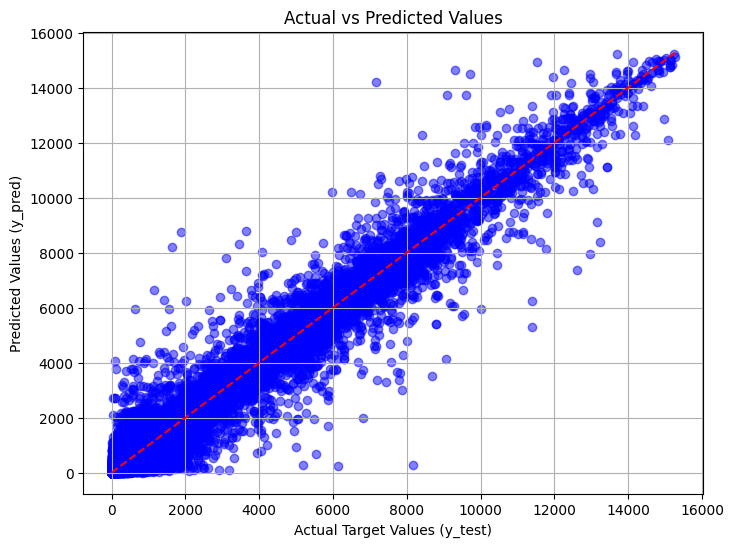

In [99]:
import matplotlib.pyplot as plt

# Plotting y_test vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Target Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

In [91]:
import pickle

# save the trained RandomForestRegressor model
with open('enefit_random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)